In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(stringr))
library(parallel)
library(patchwork)

# Read color hex code for cell types

In [2]:
color_annotation<-read.csv('/home/jupyter/BRI_Figures_Final_V2/Color_hex_codes/Cell_Type_Color_Annotation_and_Order.csv')
color_vector <- setNames(color_annotation$color, color_annotation$label)

# Read deseq2 result

In [3]:
deseq2_result_Y1D0<-read.csv('02_DEG//Deseq2_Result_Y1D0.csv')

# Count degs for age group

In [4]:
deg_counts_df <- deseq2_result_Y1D0 %>%
  filter(contrast == 'cohort.cohortGuid') %>%
  mutate(Expression = case_when(
    log2FoldChange >= 0.1 & padj <= 0.05 ~ "Up-regulated",
    log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
    TRUE ~ "Unchanged"
  )) %>%
  group_by(celltype, Expression) %>%
  summarise(count = n(), .groups = 'drop') %>%
  complete(celltype, Expression, fill = list(count = 0)) %>% 
  filter(!Expression=="Unchanged")%>%  as.data.frame()%>%
  mutate(count = case_when(
    Expression == "Down-regulated" ~ -count,
    TRUE ~ count
  ))

# Count total genes tested

In [5]:
total_counts_df<-table(deseq2_result_Y1D0 %>% 
                       filter(contrast=='cohort.cohortGuid')%>% 
                       select(celltype)) %>% as.data.frame()

# Barplot

### total gene tested 

In [6]:
total_counts_df$celltype<-factor(total_counts_df$celltype,levels=color_annotation$label)

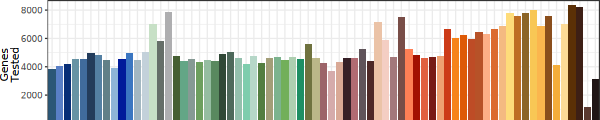

In [7]:
options(repr.plot.width = 5, repr.plot.height = 1)

p1<-ggplot(total_counts_df, aes(x=celltype, y=Freq, fill = celltype)) +
  geom_bar(stat="identity",width=0.8)+theme_bw(base_size=6)+
theme(legend.position="none")+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+ 
scale_fill_manual(values=color_vector)+ylab('Genes\nTested')+
theme(plot.margin=grid::unit(c(0,0,-2.5,0), "mm"))
p1

### deg number

In [8]:
deg_counts_df$celltype<-factor(deg_counts_df$celltype,levels=color_annotation$label)

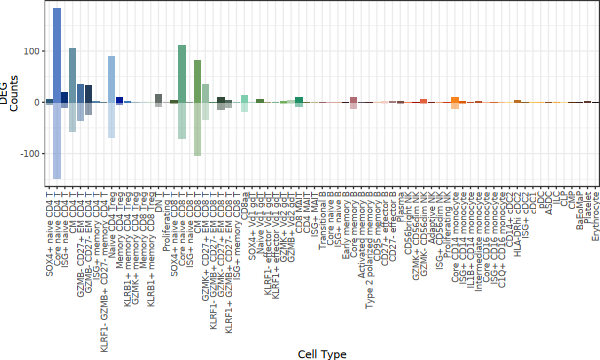

In [12]:
options(repr.plot.width = 5, repr.plot.height = 3)

p2<-ggplot(deg_counts_df, aes(x = celltype, y = count, fill = celltype)) +
  geom_bar(stat = "identity",width=0.8,aes(alpha=Expression) ) + 
scale_fill_manual(values=color_vector)+
labs(y = "DEG\nCounts", x = "Cell Type") +
  scale_alpha_manual(values = c(0.5, 1)) +
  theme_bw(base_size=6)+
theme(legend.position="none")+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
theme(plot.margin=grid::unit(c(0,0,0,-.25), "mm"))+
scale_x_discrete(labels = function(x) gsub(" cell", "", x))
p2

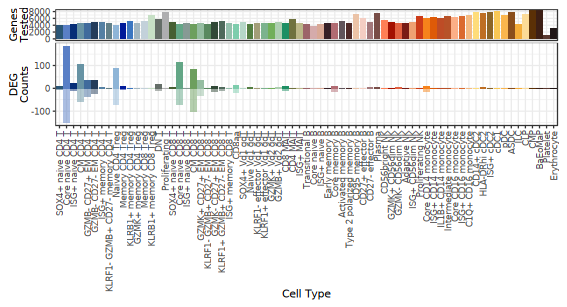

In [18]:
options(repr.plot.width = 120/25.4, repr.plot.height = 65/25.4)
combined_plot <- p1 / p2 + plot_layout(heights = c(1.5,4))
combined_plot
ggsave(filename = "FigureE.pdf", 
       plot = combined_plot, 
       width = 120/25.4, 
       height = 65/25.4)